In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np 
import matplotlib.pyplot as plt
import datetime


%load_ext tensorboard

In [2]:
dataset = tfds.load("eurosat", split="train[25%:75%]")

In [3]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))

dataset = dataset.shuffle(len(dataset))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [4]:
print("train size", train_size) 
print("val size", val_size) 
print("test size", test_size)

train size 9450
val size 2025
test size 2025


## settings

In [5]:
IMAGE_SIZE = (64,64,3) 

LABELS = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
    'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'
]
BATCH_SIZE = 16
EPOCHS = 50
TEST_SIZE = 0.18
LR = 0.001

### exploring the dataset

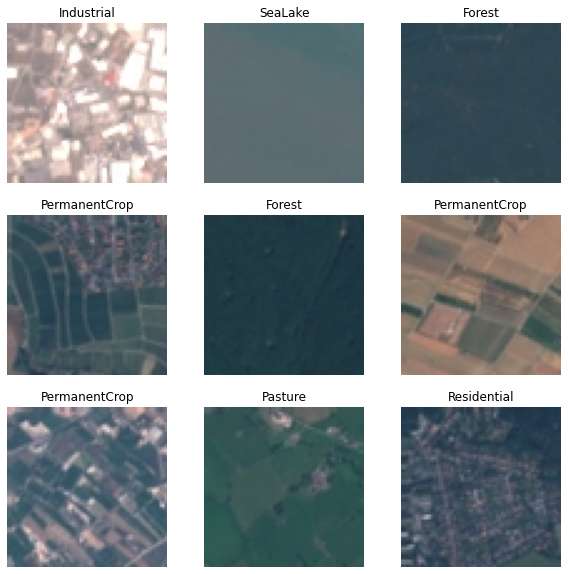

In [6]:
plt.figure(figsize=(10, 10))
for i,sample in enumerate(test_dataset.take(9)):
    image = sample["image"] 
    label = sample["label"]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(LABELS[int(label)])
    plt.axis("off")

### Tiny Resnet50

<ul>
    <li>We  perform  downsampling  directly  byconvolutional layers that have a stride of <strong>2</strong></li>
</ul>

In [7]:
def data_augmentation(): 
    
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    x = inputs
    x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")(x)
    x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.4)(x)
    
    return tf.keras.Model(inputs=[inputs], outputs=[x])

data_augm = data_augmentation()

In [8]:
def residual_block(inputs, filters, kernel_size, is_downsampled=False):
    """
        compute a complete residual block 
        Arguments: 
            inputs: an input tensor
            filters: a list of the number of filters for each conv layer 
            kernel_size: a list of kernel sizes for each conv layer
    """
    if len(filters) != len(kernel_size): 
        return None
    
    identity = inputs 
    x = inputs 
    for i in range(len(filters)): 
        if is_downsampled and i == 0: 
            x = tf.keras.layers.Conv2D(
                filters=filters[i], 
                kernel_size=kernel_size[i], 
                padding="same", 
                strides=2
            )(x)
        else: 
            x = tf.keras.layers.Conv2D(
                filters=filters[i], 
                kernel_size=kernel_size[i], 
                padding="same", 
                strides=1
            )(x)
        
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.activations.relu(x)
    if is_downsampled: 
        # we downsample the identity block by using 1x1 filters with a stride of 2
        identity = tf.keras.layers.Conv2D(filters=filters[-1], kernel_size=1, padding="same", strides=2)(identity)
    else: 
        identity = tf.keras.layers.Conv2D(filters=filters[-1], kernel_size=1, padding="same", strides=1)(identity)
    outputs = identity + x  
    outputs = tf.keras.activations.relu(outputs)
    
    return outputs


def tiny_resnet50(nb_classses, input_shape): 
    
    inputs = tf.keras.Input(shape=(64,64,3)) 
    
    x_augm = data_augm(inputs)
    
    first_conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x_augm)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(first_conv)
    
    # stacking residual blocks
    all_filters = [
        [28,28, 64], 
        [128,128,128], 
        [256,256,256]
    ]
    
    kernel_sizes = [1,3,1]
    
    for filters in all_filters: 
        for i in range(2): 
            if i == 0: 
                downsample = True
            else: 
                downsample = False
            
            x = residual_block(x,filters,kernel_sizes, is_downsampled=downsample)
            
    
    x = tf.keras.layers.AveragePooling2D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nb_classses)(x)
    outputs = tf.keras.activations.sigmoid(x)
    
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model
    
    

In [9]:
resnet50 = tiny_resnet50(len(LABELS), IMAGE_SIZE)
print(IMAGE_SIZE)

(64, 64, 3)


In [10]:
resnet50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 64, 64, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        model[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
____________________________________________________________________________________________

In [11]:
def preprocess_data(sample):
    image = tf.cast(sample["image"], dtype=tf.float32)
    label = tf.one_hot(
        sample["label"], 
        depth=len(LABELS)
    )
    
    return (image, label)

### Training 

In [12]:
# lr decay 

def lrdecay(epoch, lr): 
    k = 0.05
    if epoch >= 10: 
        lr = lr * np.exp(-k*epoch) 
    return lr

In [13]:
log_dir = F"logs/fit/lr={LR}_decay_{EPOCHS}epochs_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tensorboard_callback, 
    tf.keras.callbacks.ModelCheckpoint("best_model.h5",save_best_only=True), 
    tf.keras.callbacks.LearningRateScheduler(lrdecay, verbose=1)
]

### Do not run if you've already trained the model

In [14]:
train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)

train_dataset = train_dataset.batch(BATCH_SIZE) 
val_dataset = val_dataset.batch(BATCH_SIZE)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [15]:
resnet50.compile(
    optimizer=tf.keras.optimizers.SGD(LR),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [16]:
resnet50.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=val_dataset,
)


Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
591/591 [==============================] - 17s 22ms/step - loss: 1.9928 - accuracy: 0.1715 - val_loss: 1.7759 - val_accuracy: 0.2548
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
591/591 [==============================] - 12s 21ms/step - loss: 1.4458 - accuracy: 0.4813 - val_loss: 1.5502 - val_accuracy: 0.4049
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
591/591 [==============================] - 13s 21ms/step - loss: 1.2248 - accuracy: 0.5621 - val_loss: 1.6731 - val_accuracy: 0.3832
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
591/591 [==============================] - 12s 21ms/step - loss: 1.1463 - accuracy: 0.5826 - val_loss: 1.2321 - val_accuracy: 0.5704
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001000000

591/591 [==============================] - 12s 20ms/step - loss: 0.7325 - accuracy: 0.7379 - val_loss: 0.6541 - val_accuracy: 0.7743
Epoch 37/50

Epoch 00037: LearningRateScheduler reducing learning rate to 3.274585019886572e-17.
591/591 [==============================] - 12s 20ms/step - loss: 0.7332 - accuracy: 0.7361 - val_loss: 0.6686 - val_accuracy: 0.7565
Epoch 38/50

Epoch 00038: LearningRateScheduler reducing learning rate to 5.148864721030077e-18.
591/591 [==============================] - 12s 20ms/step - loss: 0.7383 - accuracy: 0.7410 - val_loss: 0.6936 - val_accuracy: 0.7486
Epoch 39/50

Epoch 00039: LearningRateScheduler reducing learning rate to 7.701085865228728e-19.
591/591 [==============================] - 12s 20ms/step - loss: 0.7315 - accuracy: 0.7412 - val_loss: 0.6491 - val_accuracy: 0.7699
Epoch 40/50

Epoch 00040: LearningRateScheduler reducing learning rate to 1.0956648073726567e-19.
591/591 [==============================] - 12s 20ms/step - loss: 0.7254 - accur

In [17]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6007 (pid 7453), started 4:28:32 ago. (Use '!kill 7453' to kill it.)

## Observations of the naïve resnet50 model

### The model is overfitting with basic data augm, lr=0.01, no dropout

<p>Possible solutions for this problem</p>

<ol>
    <li>More data</li>
    <li>Adding Data Augmentation </li>
    <li>Adding regularization (Lr decay, Dropout)</li>
    <li>Reduce complexity</li>
</ol>

### Let's test our model

In [18]:
# load the model
model = tf.keras.models.load_model("best_model.h5")

In [19]:
def get_true_label(image, label): 
    return tf.math.argmax(label)

In [20]:
test_dataset = test_dataset.map(preprocess_data)
true_label = test_dataset.map(get_true_label)

In [21]:
test_dataset = test_dataset.batch(BATCH_SIZE) 
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
probs = model.predict(test_dataset)

In [22]:
predictions = np.argmax(probs, axis=1)
print(predictions)

[2 3 7 ... 8 2 7]


In [23]:
true_label = np.array(list(true_label.as_numpy_iterator()))
print(true_label)

[0 1 2 ... 2 5 3]


In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [25]:
conf_mat = confusion_matrix(predictions, true_label)
score = f1_score(predictions, true_label,labels=range(len(LABELS)), average='macro')
precision = precision_score(predictions, true_label, labels=range(len(LABELS)), average='macro')

In [26]:
def display_confusion_matrix(cmat):
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(LABELS)))
    ax.set_yticklabels(LABELS)
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #titlestring = ""
    #if score is not None:
    #    titlestring += 'f1 = {:.3f} '.format(score)
    #if precision is not None:
    #    titlestring += '\nprecision = {:.3f} '.format(precision)
    #if recall is not None:
    #    titlestring += '\nrecall = {:.3f} '.format(recall)
    #if len(titlestring) > 0:
    #    ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()


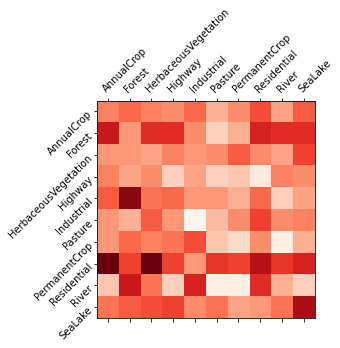

f1 : 9.31334151103232 % , precision : 9.383708263308506 % 


In [27]:
display_confusion_matrix(conf_mat)
print(f"f1 : {score * 100} % , precision : {precision * 100} % ")